# Dataset preprocessing

In [1]:
#Imports

import numpy as np 
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', 150)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')
%cd '/content/gdrive/MyDrive/ML_projects/NLP_Disaster_Tweets'

Mounted at /content/gdrive/
/content/gdrive/MyDrive/ML_projects/NLP_Disaster_Tweets


In [3]:
#Let's read and look at the dataset.

df = pd.read_csv('disaster_tweets.csv', index_col=0)
df

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1


In [4]:
#Checking how many missing values this dataset contains.

df.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
#Now unnecessary 'location' column and rows with missing values.
#Also, let's drop duplicates if there are any.

df.drop(columns = 'location', inplace = True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop = True, inplace=True)

In [6]:
#The dataset no longer contains missing values.

df.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

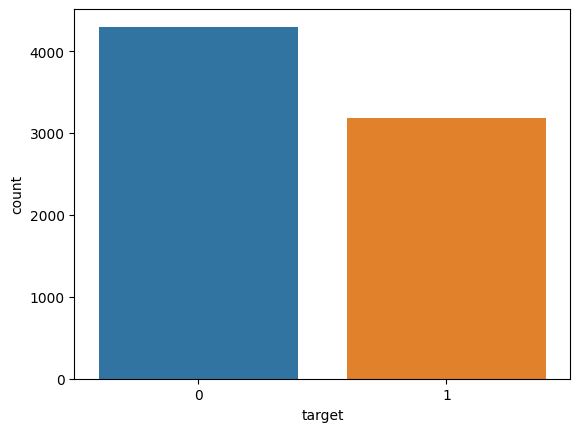

In [7]:
#The dataset seems quite balanced.

sns.countplot(x = df['target'], label='target');

In [8]:
#Let's merge the 'text' and 'keyword' columns to create one united column.

df['text_keywords'] = df['text'] + ' ' + df['keyword']
df.drop(columns = ['keyword','text'], inplace = True)
df

,target,text_keywords
0,1,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C ablaze
1,0,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw ablaze
2,1,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi ablaze
3,0,Crying out for more! Set me ablaze ablaze
4,0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N ablaze
...,...,...
7475,0,@jt_ruff23 @cameronhacker and I wrecked you both wrecked
7476,0,Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one wrecked
7477,0,#FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM wrecked
7478,0,@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO wrecked


# Text Preprocessing

In [9]:
#Now let's work on the function for the text preprocessing.
#It is going to remove punctuation, stopwords, links, and usernames. 
#Also, it is going to apply lemmatization (the process of converting a word to its base form).

def text_preprocessing(text):
    custom_punct = string.punctuation.replace('@', '')
    no_punct = [i for i in text if i not in custom_punct]
    no_punct = "".join(no_punct)
    new_text = [] 
    for t in no_punct.split():
        t = 'USER' if t.startswith('@') and len(t) > 1 else t
        t = 'HTTP' if t.startswith('http') else t
        new_text.append(t)
    new_text = " ".join(new_text)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['USER', 'HTTP'])
    no_stop_words = [i for i in new_text.split() if i not in stop_words]
    lowercase = [i.lower() for i in no_stop_words]
    lowercase = [i.lower() for i in no_stop_words]
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_text = [wordnet_lemmatizer.lemmatize(word) for word in lowercase]
    return ' '.join(lemma_text)

In [10]:
#Let's apply this function to the text data.

df['text'] = df['text_keywords'].apply(lambda x: text_preprocessing(x))
df

,target,text_keywords,text
0,1,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C ablaze,wholesale market ablaze ablaze
1,0,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw ablaze,we always try bring heavy metal rt ablaze
2,1,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi ablaze,africanbaze breaking newsnigeria flag set ablaze aba ablaze
3,0,Crying out for more! Set me ablaze ablaze,cry set ablaze ablaze
4,0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N ablaze,on plus side look at the sky last night it wa ablaze ablaze
...,...,...,...
7475,0,@jt_ruff23 @cameronhacker and I wrecked you both wrecked,i wrecked wrecked
7476,0,Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one wrecked,three day work theyve pretty much wrecked hahaha shoutout family one wrecked
7477,0,#FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM wrecked,fx forex trading cramer igers 3 word wrecked disney stock wrecked
7478,0,@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO wrecked,great atmosphere british lion gig tonight hearing wrecked wrecked


# Train-test split

In [11]:
#Now let's split data into train and test datasets.

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5984,) (5984,)
(1496,) (1496,)


# GridSearch Parameters

In [12]:
#Let's prepare parameters for GridSearch. 
#These are parameters for both vectorizers and linear models.

#CountVectorizer

param_countvect = {'vectorizer__max_df': [0.5, 0.75, 1.0],
        'vectorizer__max_features': [None, 5000, 10000, 50000],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)]}

In [13]:
#TfidfVectorizer

param_tfidf = {'vectorizer__max_df': [0.5, 0.75, 1.0],
            'vectorizer__max_features': [None, 5000, 10000, 50000],
            'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
            'vectorizer__norm': ['l1', 'l2', None]}

In [14]:
#LogisticRegression

param_logreg = {'model__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
        'model__C' : [100, 10, 1.0, 0.1, 0.01, 0.001],
        'model__max_iter': [10000]}

In [15]:
#Multinomial Naive Bayes classifier

param_nb = {'model__alpha': [0.0001, 0.001, 0.01, 1.0, 10, 100]}

In [16]:
#Random Forest Classifier

param_rf = {'model__max_depth' : [5,10,15,20],
            'model__bootstrap' : [True, False]}

# Combinations of Vectorizers and Linear Models

In [17]:
#Now let's see which results will give different combinations of vectorizers and classifiers.

list_vect = [(CountVectorizer(), param_countvect), (TfidfVectorizer(), param_tfidf)]
list_models = [(LogisticRegression(), param_logreg), (MultinomialNB(), param_nb), (RandomForestClassifier(), param_rf)]

In [18]:
for v in list_vect:
    for m in list_models:
        pipeline = Pipeline([("vectorizer", v[0]), ("model", m[0])])
        dict_params = {}
        dict_params.update(v[1])
        dict_params.update(m[1])

        GridSearch = GridSearchCV(pipeline, dict_params, scoring='roc_auc', n_jobs = -1, cv = 3)
        GridSearch.fit(X_train, y_train)
        
        y_pred = GridSearch.predict(X_test)       
        class_report = classification_report(y_test, y_pred)
        print(GridSearch.best_params_)
        print('\nPipeline:', pipeline)
        print('\nBest Params:', GridSearch.best_params_)
        print(f'\n Combination of {v[0]} + {m[0]} gives:')
        print('\n', class_report)

{'model__C': 0.1, 'model__max_iter': 10000, 'model__solver': 'newton-cg', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 2)}

Pipeline: Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('model', LogisticRegression())])

Best Params: {'model__C': 0.1, 'model__max_iter': 10000, 'model__solver': 'newton-cg', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 2)}

 Combination of CountVectorizer() + LogisticRegression() gives:

               precision    recall  f1-score   support

           0       0.80      0.88      0.83       867
           1       0.80      0.69      0.74       629

    accuracy                           0.80      1496
   macro avg       0.80      0.78      0.79      1496
weighted avg       0.80      0.80      0.80      1496

{'model__alpha': 1.0, 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 1)}

Pipeline: Pipeline(st

# Conclusion

We can notice that the following combinations are beneficial for this classification task:
* CountVectorizer + LogisticRegression
* TfidfVectorizer + LogisticRegression
* TfidfVectorizer + MultinomialNB

All these combinations have an accuracy score of 0.8. LogisticRegression works well both with CountVectorizer and TfidfVectorizer.
